# CS 6220 Data Mining — Assignment 1

# Exploring the MovieLens 1M Dataset

## **Code**

In [3]:
import pandas as pd

In [5]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('ml-1m/users.dat', sep='::', header=None, names=unames, engine='python', encoding='latin-1')

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python', encoding='latin-1')

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('ml-1m/movies.dat', sep='::', header=None, names=mnames, engine='python', encoding='latin-1')


Having all information spread across different tables makes it much more dificult to analyse the data. Using pandas's merge function, we first merge ratings with users then we merge that result with the movies data. pandas infers which columns to
use as the merge (or join) keys based on overlapping names:

In [8]:
data = pd.merge(pd.merge(ratings, users), movies)

In [10]:
mean_ratings = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')

In [12]:
ratings_by_title = data.groupby('title').size()

In [14]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]

In [16]:
mean_ratings = mean_ratings.loc[active_titles]


In [18]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)

In [20]:
top_male_ratings = mean_ratings.sort_values(by='M', ascending=False)

In [22]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

In [24]:
sorted_by_diff = mean_ratings.sort_values(by='diff')

# 1. An aggregate of movie ratings by men of age above 25 for each particular genre,e.g., Action, Adventure, Drama, Science Fiction etc. Note that Action|Drama|Thriller’ is not considered a unique genre. The movie that has a genre like this belongs to all three genres.

In [33]:
# Filter data for male users over 25
data_men_over_25 = data[(data['gender'] == 'M') & (data['age'] > 25)]

# Split the 'genres' column into multiple genres
genres_split = data_men_over_25['genres'].str.get_dummies('|')

# Multiply each genre by the rating to distribute ratings across genres
ratings_by_genre = genres_split.multiply(data_men_over_25['rating'], axis=0)

# Calculate the total number of ratings for each genre
total_ratings_per_genre = genres_split.sum()

# Calculate the average rating for each genre by dividing the total ratings by the count of ratings
avg_ratings_by_genre = ratings_by_genre.sum() / total_ratings_per_genre

# Display the average ratings for each genre
print(avg_ratings_by_genre)


Action         3.554547
Adventure      3.538637
Animation      3.721569
Children's     3.475314
Comedy         3.565456
Crime          3.764249
Documentary    3.950192
Drama          3.812309
Fantasy        3.490408
Film-Noir      4.117140
Horror         3.241089
Musical        3.700242
Mystery        3.759347
Romance        3.659748
Sci-Fi         3.509693
Thriller       3.644025
War            3.940634
Western        3.708494
dtype: float64


The solution outputs the average rating for each genre, aggregated by men over 25. For example, genres like Action, Drama, and Comedy will show their respective average ratings based on how male users over 25 rated movies in those genres.

# 2. The top 5 ranked movies by the most number of ratings (not the highest rating).

In [37]:
# Group the data by movie title and count the number of ratings each movie received
ratings_by_movie = data.groupby('title').size()

# Sort the movies by the number of ratings in descending order
top_5_movies = ratings_by_movie.sort_values(ascending=False).head(5)

# Display the top 5 movies by the number of ratings
print(top_5_movies)


title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
dtype: int64


The result shows the top 5 movies ranked by the number of user ratings they received. "American Beauty (1999)" leads with the most ratings at 3428, followed closely by the original "Star Wars" trilogy with nearly 3000 ratings each. "Jurassic Park (1993)" also appears in the top 5, showing its popularity and widespread viewership. This ranking emphasizes the most popular movies in terms of engagement, regardless of the actual ratings given by users.

# 3. Average movie ratings between users of different age groups (<18, 18-30, 30-50, 50-70, 70>)

In [41]:
age_mapping = {
    1: '<18',     # "Under 18"
    18: '18-30',  # "18-24"
    25: '18-30',  # "25-34" -> Assigned to 18-30 for simplicity
    35: '30-50',  # "35-44"
    45: '30-50',  # "45-49"
    50: '50-70',  # "50-55"
    56: '50-70'   # "56+" -> Includes users older than 70
}

# Create a new column 'age_group_mapped' in the data based on the mapping
data['age_group_mapped'] = data['age'].map(age_mapping)

# Group the data by the remapped age group and calculate the average rating
avg_ratings_by_age_group = data.groupby('age_group_mapped')['rating'].mean()

# Display the average ratings for each age group
print(avg_ratings_by_age_group)


age_group_mapped
18-30    3.533299
30-50    3.624050
50-70    3.732677
<18      3.549520
Name: rating, dtype: float64


The result shows the average movie ratings across different age groups.
This breakdown helps highlight how movie preferences and rating behaviors can vary significantly between different age demographics.

# 4. Pick a movie of your choice and for all movies of the same year, provide a breakdown of the number of unique movies rated by 3 ranges of age of reviewers (a) under 18 (b) 19 to 45 (c) Above 45.

In [45]:
chosen_movie = 'Star Wars: Episode IV - A New Hope (1977)'
chosen_movie_year = data[data['title'] == chosen_movie]['title'].str.extract(r'\((\d{4})\)').iloc[0, 0]

# Filter the dataset for movies released in the same year
movies_same_year = data[data['title'].str.contains(rf'\({chosen_movie_year}\)')].copy()

# Define new age groups for the analysis
age_groups = {
    1: '<18',     # "Under 18"
    18: '19-45',  # "18-24" falls into the 19-45 range
    25: '19-45',  # "25-34"
    35: '19-45',  # "35-44"
    45: '19-45',  # "45-49"
    50: '>45',    # "50-55"
    56: '>45'     # "56+"
}

# Create a new column 'age_group_task4' using the new age group mapping
movies_same_year['age_group_task4'] = movies_same_year['age'].map(age_groups)

# Group by the new age groups and calculate the number of unique movies rated by each group
unique_movies_by_age_group = movies_same_year.groupby('age_group_task4')['title'].nunique()

# Display the number of unique movies rated by each age group
print(unique_movies_by_age_group)


age_group_task4
19-45    22
<18      16
>45      21
Name: title, dtype: int64


The result presents the number of unique movies rated by different age groups for movies released in the same year as "Star Wars: Episode IV - A New Hope (1977)". 

# 5. A function that takes in a user_id and a movie_id, and returns a list of all the other movies that the user rated similarly to the given movie, i.e. with the same rating. Demonstrate that your function works.

In [49]:
def find_similar_rated_movies(user_id, movie_id):
    # Retrieve the rating the user gave to the specified movie
    user_rating = data[(data['user_id'] == user_id) & (data['movie_id'] == movie_id)]
    
    if user_rating.empty:
        return f"No rating found for user {user_id} and movie {movie_id}"
    
    # Get the rating value
    rating_value = user_rating['rating'].values[0]
    
    # Find all movies the user rated with the same rating, excluding the given movie
    similar_rated_movies = data[(data['user_id'] == user_id) & (data['rating'] == rating_value) & (data['movie_id'] != movie_id)]
    
    # Return a list of movie titles that the user rated similarly
    return similar_rated_movies['title'].tolist()

# Testing the function with a sample user_id and movie_id
user_id_example = 1  # Example user
movie_id_example = 1193  # Example movie (ID for "One Flew Over the Cuckoo's Nest")
similar_movies = find_similar_rated_movies(user_id_example, movie_id_example)

print(f"Movies rated similarly by user {user_id_example}:")
print(similar_movies)


Movies rated similarly by user 1:
["Bug's Life, A (1998)", 'Ben-Hur (1959)', 'Christmas Story, A (1983)', 'Beauty and the Beast (1991)', 'Sound of Music, The (1965)', 'Awakenings (1990)', 'Back to the Future (1985)', "Schindler's List (1993)", 'Pocahontas (1995)', 'Last Days of Disco, The (1998)', 'Cinderella (1950)', 'Apollo 13 (1995)', 'Toy Story (1995)', 'Rain Man (1988)', 'Mary Poppins (1964)', 'Dumbo (1941)', 'Saving Private Ryan (1998)']


The function successfully returns a list of movies that user 1 rated similarly to "One Flew Over the Cuckoo's Nest". The list includes a variety of classic films such as "Schindler's List (1993)", "Back to the Future (1985)", and animated features like "Beauty and the Beast (1991)".

# 6. Some other statistic, figure, aggregate, or plot that you created using this dataset, along with a short description of what interesting observations you derived from it.

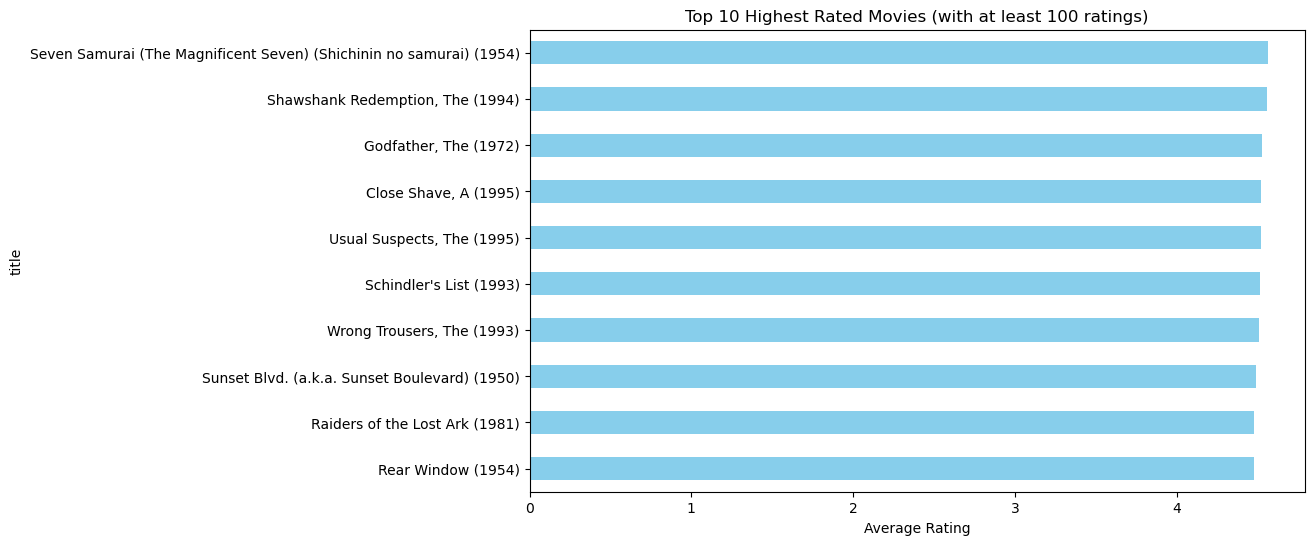

In [53]:
import matplotlib.pyplot as plt

# Group by title and calculate the average rating for each movie
avg_movie_ratings = data.groupby('title')['rating'].mean()

# Count the number of ratings for each movie
ratings_count = data.groupby('title').size()

# Filter to movies with at least 100 ratings
popular_movies = avg_movie_ratings[ratings_count >= 100]

# Sort the movies by average rating in descending order and select the top 10
top_10_movies = popular_movies.sort_values(ascending=False).head(10)

# Plot the top 10 movies
plt.figure(figsize=(10, 6))
top_10_movies.plot(kind='barh', color='skyblue')
plt.xlabel('Average Rating')
plt.title('Top 10 Highest Rated Movies (with at least 100 ratings)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rated movie on top
plt.show()


The bar plot illustrates the Top 10 highest-rated movies with at least 100 ratings. The results highlight that movies like "Seven Samurai (1954)", "The Shawshank Redemption (1994)", and "The Godfather (1972)" are highly regarded by users. Interestingly, animated shorts such as "The Wrong Trousers (1993)" also appear in the top rankings, showing that even shorter films can achieve high praise. This provides a clear view of user preferences for well-established, critically acclaimed films.